In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from matplotlib.colors import LogNorm

In [4]:
ffnn = tf.keras.models.load_model('models/FFNN_JLA2.h5') 
latent_dim = 1
decoder = tf.keras.models.load_model('models/vaeffnn_decoder.h5', custom_objects={'latent_dim': latent_dim})
encoder = tf.keras.models.load_model('models/vaeffnn_encoder.h5')
ffnn_do = tf.keras.models.load_model('models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})
#ffnn_do 2 and without 2


In [6]:
syscov = np.loadtxt('data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = 'data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)


-0.01084098704 0.02815552265 0.00039265133851975654


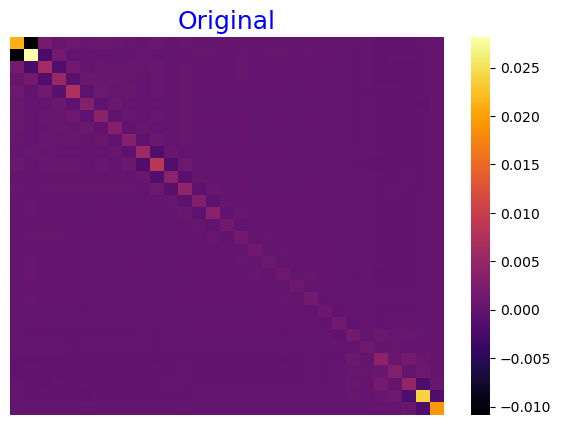

In [7]:
plt.figure(figsize=(7, 5), dpi=100)

plt.title('Original', fontsize=18, color='blue')
sns.heatmap(syscov, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

plt.savefig('originalcov.png')

In [8]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

In [9]:
zseedlog = np.linspace(np.log10(0.01), np.log10(1.3), 31)
zpoints = 10**zseedlog
# zpoints = z_redshift
# zpoints = ranz+0.01*np.random.randn(31)
# orderMag(0.1)
# zpoints = zpoints+ 0.01*np.random.rand(31)
zpoints

array([0.01      , 0.01176156, 0.01383342, 0.01627025, 0.01913635,
       0.02250733, 0.02647212, 0.03113533, 0.03661999, 0.04307081,
       0.05065797, 0.05958166, 0.0700773 , 0.0824218 , 0.09694087,
       0.11401754, 0.13410237, 0.15772525, 0.18550944, 0.21818796,
       0.25662299, 0.30182857, 0.35499736, 0.41753213, 0.49108275,
       0.57758973, 0.67933539, 0.79900412, 0.93975316, 1.10529594,
       1.3       ])

In [10]:
ztest2 = encoder.predict(syscov.reshape((-1,31*31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
mean_ref = np.mean(dist)
std_ref = np.std(dist)
delta_mean = z_sample_syscov - mean_ref


In [11]:
pred_random = ffnn.predict(np.log10(zpoints))
# pred_random = ffnn.predict(zpoints)
dlfake = scalerdist.inverse_transform(pred_random.reshape(-1,1))
index = np.argsort(zpoints)
dlfake = dlfake.reshape(31,)[index]
zpoints = zpoints[index]
fake_data = np.stack((zpoints, dlfake), axis=1)

# np.savetxt("fake_binned_JLA_inter.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [12]:
mean_pred_interpoint = np.mean(dlfake)
std_pred_interpoint = np.std(dlfake)

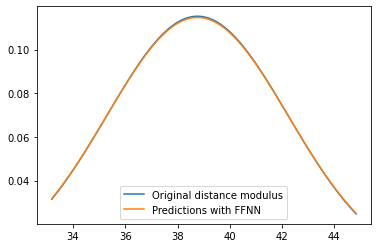

In [13]:
xmin = np.min(dlfake)
xmax= np.max(dlfake)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)

plt.plot(x, y1, label='Original distance modulus')
plt.plot(x, y2, label='Predictions with FFNN')

# plt.show()
# dist_sc
plt.legend()

In [14]:
z_sample = np.array([mean_pred_interpoint+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)


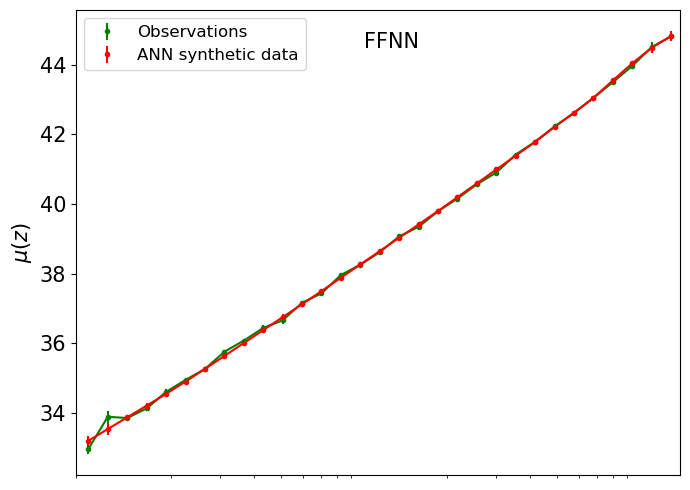

In [15]:
plt.figure(figsize=(7, 5), dpi=100)
# plt.scatter(z_redshift, dist,c='g', label='Observations')
# plt.scatter(zpoints, dlfake, c='r', label='Synthetic data', marker='*')
plt.errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
plt.plot(z_redshift, dist, c='g')
plt.errorbar(zpoints, dlfake, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.', label='ANN synthetic data')
plt.plot(zpoints, dlfake, c='r')

plt.xscale('log')
# plt.xlabel([])
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xlim(0.009, 1.4)

plt.xticks([])
plt.text(0.1, 44.5, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=12)

plt.savefig('JLA_FFNN_original.png')

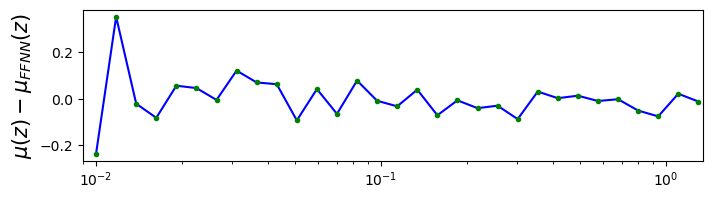

In [16]:
plt.figure(figsize=(8, 2), dpi=100)

mudiff = np.subtract(dist, dlfake.reshape(31,))
errdiff = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr)))
                                    
plt.errorbar(z_redshift, mudiff, yerr=errdiff, c='g',  fmt='.')
# plt.errorbar(zpoints, mudiff, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.')
plt.plot(z_redshift, mudiff, c='b')
plt.xlim(0.009, 1.35)
# plt.xlabel('Redshift $z$')
plt.xscale('log')

# plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("$\mu(z) - \mu_{FFNN}(z)$", fontsize=15)
plt.savefig("Diferences_mod.png")

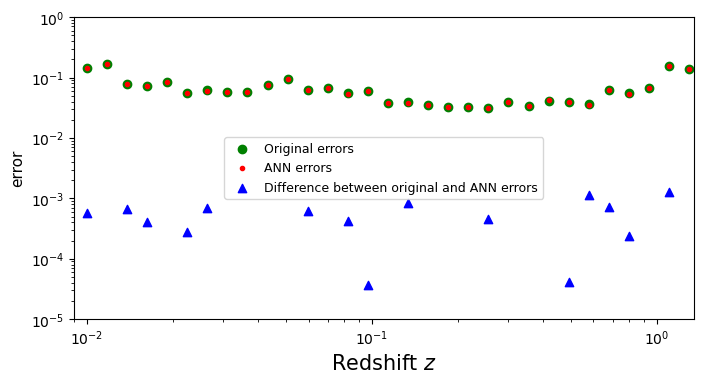

In [17]:
plt.figure(figsize=(8, 4), dpi=100)

mudiff = np.subtract(dist, dlfake.reshape(31,))
errdiff = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr)))
                                    
plt.scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
plt.scatter(zpoints, np.sqrt(np.diag(newmatrixr)), c='r', marker='.', label='ANN errors')
plt.scatter(z_redshift, errdiff, c='b', \
            marker='^', label="Difference between original and ANN errors" )
plt.xlim(0.009, 1.35)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("error", fontsize=11)
plt.legend(fontsize=9, loc='center')
# plt.savefig('errors_original_redshifts.png')


In [18]:
def RHSquared_a_owacdm(a, w0, wa, Om):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r
    
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+43

zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

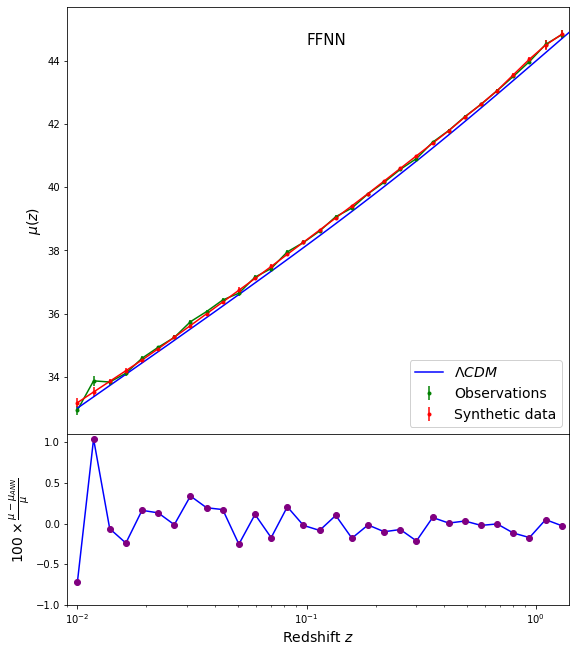

In [19]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
axs[0].plot(z_redshift, dist, c='g')
axs[0].errorbar(zpoints, dlfake, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.', label='Synthetic data')
axs[0].plot(zpoints, dlfake, c='r')
axs[0].plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].fill_between(zmodel, flcdm - 1*0.104, flcdm + 1*0.104, alpha=0.5)
# axs[0].plot(zmodel, fowacdm1, label='CPL $w_0 = -1.09, w_a=0.3', c='m')
axs[0].set_ylabel("$\mu(z)$", fontsize=14)
axs[0].set_xscale('log')
axs[0].set_xlim(0.009, 1.4)
axs[0].set_xticks([])
axs[0].text(0.1, 44.5, 'FFNN', fontsize=15)
axs[0].legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            

axs[1].errorbar(z_redshift, 100*(mudiff/dist), yerr=errdiff, c='purple',  fmt='o')
axs[1].plot(z_redshift, 100*(mudiff/dist), c='b')
axs[1].set_xlim(0.009, 1.4)
axs[1].set_ylim(-1, 1.1)
# axs[1].set_ylabel(r"$ \frac{\mu - \mu_{ANN}}{\mu}$", fontsize=14)
axs[1].set_ylabel(r"$100\times\frac{\mu - \mu_{ANN}}{\mu}$", fontsize=14)
axs[1].set_xscale('log')



# axs[2].scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
# axs[2].scatter(zpoints, np.sqrt(np.diag(newmatrixr)), c='r', marker='.', label='ANN errors')
# axs[2].scatter(z_redshift, errdiff, c='b', \
#                 marker='^', label="Difference between original and ANN errors" )

# axs[2].set_xlim(0.009, 1.4)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-5, 1)
# axs[2].set_ylabel("error", fontsize=14)
# axs[2].legend(fontsize=10, loc='center', framealpha=1, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# for a in axs:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

plt.savefig('ffnn_jla.png')

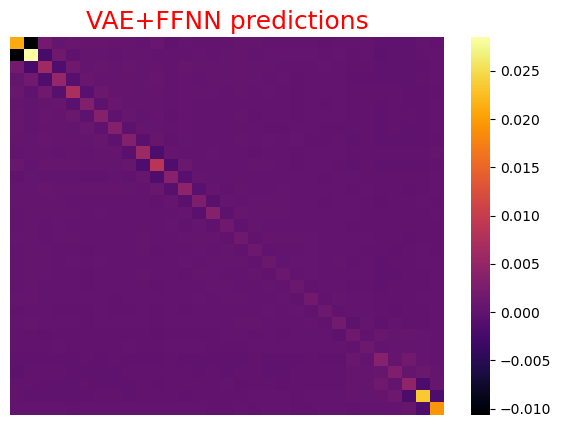

In [20]:
plt.figure(figsize=(7, 5), dpi=100)
plt.title('VAE+FFNN predictions', fontsize=18, color='red')

sns.heatmap(newmatrixr, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVAE_DO.dat", newmatrixr_do, delimiter= " ", header="#fake COV")
plt.savefig('vae_cov_ffnn.png')

# Now with MC-DO

In [21]:
pred_random = ffnn_do.predict(np.log10(zpoints))
dlfake_do = scalerdist.inverse_transform(pred_random[:,0].reshape(-1,1))
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake_do.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLADO_inter.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

<ipython-input-22-b3c551a876cc>:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(-0.0, np.max(z_redshift)+0.1)


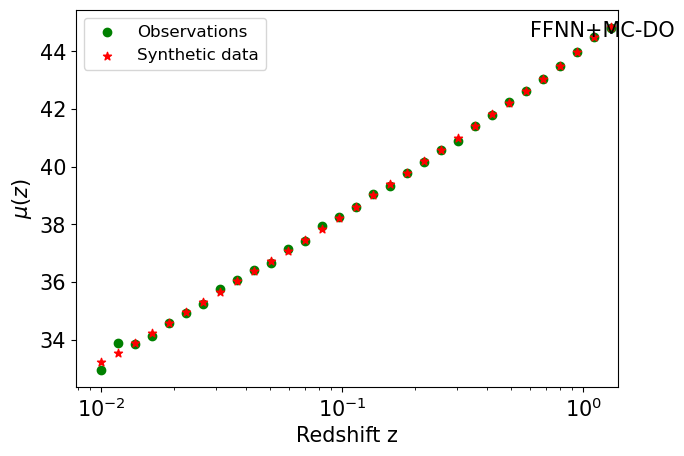

In [22]:
plt.figure(figsize=(7, 5), dpi=100)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(zpoints, dlfake_do, c='r', label='Synthetic data', marker='*')

plt.xscale('log')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 44.5, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
# plt.tight_layout()
plt.legend(fontsize=12)

In [23]:
mean_pred_interpoint_DO = np.mean(dlfake_do)
std_pred_interpoint_DO = np.std(dlfake_do)

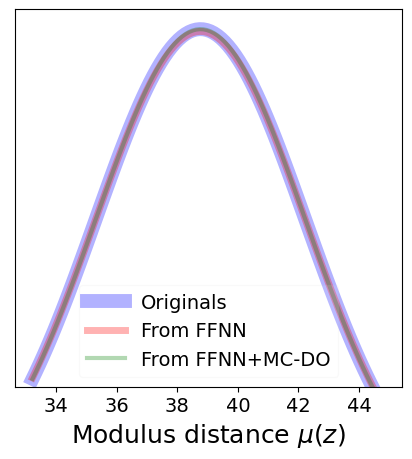

In [24]:
plt.figure(figsize=(5, 5), dpi=100, facecolor='white')
# plt.grid(b=None)

xmin = np.min(dlfake_do)
xmax= np.max(dlfake_do)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)
y3 = sp.stats.norm.pdf(x, mean_pred_interpoint_DO, std_pred_interpoint_DO)


plt.plot(x, y1, label='Originals', color='blue', linewidth=10, alpha=0.3)
plt.plot(x, y2, label='From FFNN', color='red', linewidth=5, alpha=0.3)
plt.plot(x, y3, label='From FFNN+MC-DO', color='green', linewidth=3, alpha=0.3)
plt.ylim(0.03,0.12)

# plt.grid(True)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# plt.show()
# dist_sc
# plt.yscale('log')
plt.legend(fontsize=14, loc='lower center', framealpha=0.1)
plt.yticks([])
plt.xticks(fontsize=14)

plt.xlabel("Modulus distance $\mu (z)$", fontsize=18)
plt.savefig('modulus_dist_gauss.png')

In [25]:
# plt.figure(figsize=(7, 7), dpi=100)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# # dist_sc
# plt.legend(fontsize=15)
# plt.yticks([])
# plt.xticks(fontsize=15)

In [26]:
z_sample = np.array([mean_pred_interpoint_DO+delta_mean])

newmatrix_do = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr_do = newmatrix_do.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)


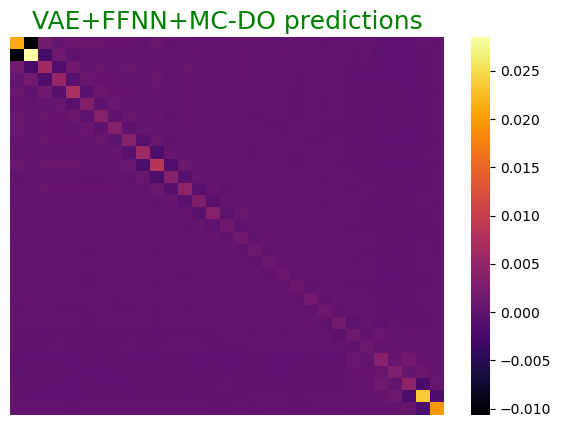

In [27]:
plt.figure(figsize=(7, 5), dpi=100)
plt.title('VAE+FFNN+MC-DO predictions', fontsize=18, color='green')

sns.heatmap(newmatrixr_do, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVAE_DO.dat", newmatrixr_do, delimiter= " ", header="#fake COV")
plt.savefig('vae_cov_ffnn_do.png')

Text(0, 0.5, '$\\mu(z) - \\mu_{FFNN}(z)$')

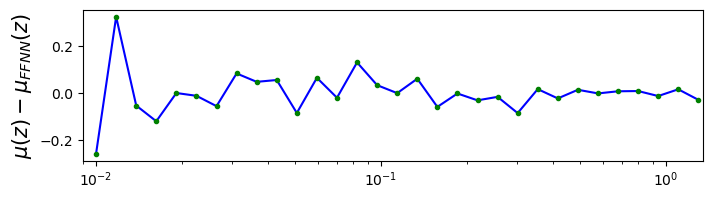

In [28]:
plt.figure(figsize=(8, 2), dpi=100)

mudiff_do = np.subtract(dist, dlfake_do.reshape(31,))
errdiff_do = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr_do)))
                                    
plt.errorbar(z_redshift, mudiff_do, yerr=errdiff, c='g',  fmt='.')
# plt.errorbar(zpoints, mudiff, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.')
plt.plot(z_redshift, mudiff_do, c='b')
plt.xlim(0.009, 1.35)

# plt.xlabel('Redshift $z$')
plt.xscale('log')

# plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("$\mu(z) - \mu_{FFNN}(z)$", fontsize=15)
# plt.savefig("Diferences_mod.png")

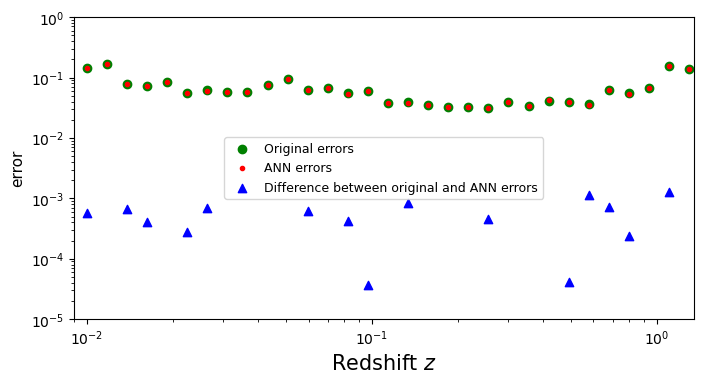

In [29]:
plt.figure(figsize=(8, 4), dpi=100)

mudiff_do = np.subtract(dist, dlfake_do.reshape(31,))
errdiff_do = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr_do)))
                                    
plt.scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
plt.scatter(zpoints, np.sqrt(np.diag(newmatrixr_do)), c='r', marker='.', label='ANN errors')
plt.scatter(z_redshift, errdiff_do, c='b', \
            marker='^', label="Difference between original and ANN errors" )
plt.xlim(0.009, 1.35)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("error", fontsize=11)
plt.legend(fontsize=9, loc='center')

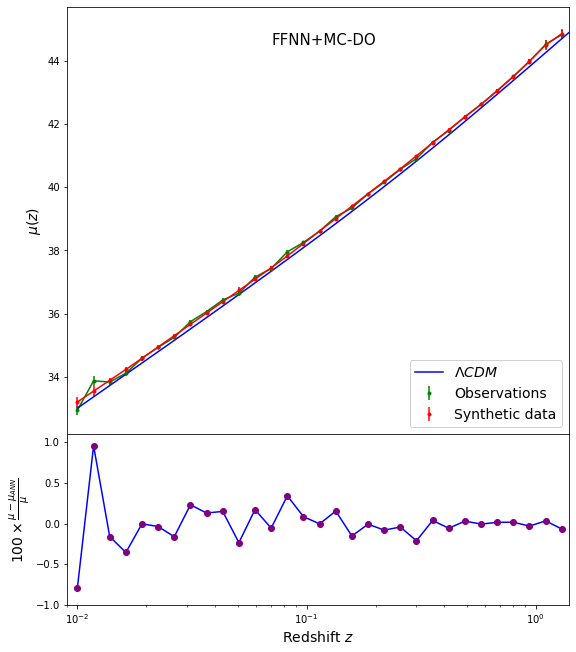

In [30]:
fig, axs = plt.subplots(2,1, figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
axs[0].plot(z_redshift, dist, c='g')
axs[0].errorbar(zpoints, dlfake_do, yerr=np.sqrt(np.diag(newmatrixr_do)), c='r',  fmt='.', label='Synthetic data')
axs[0].plot(zpoints, dlfake_do, c='r')
axs[0].plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].plot(zmodel, fowacdm2, label='CPL $w_0 = -1.04, w_a=-0.3', c='m')
axs[0].set_ylabel("$\mu(z)$", fontsize=14)
axs[0].set_xscale('log')
axs[0].set_xlim(0.009, 1.4)
axs[0].set_xticks([])
axs[0].text(0.07, 44.5, 'FFNN+MC-DO', fontsize=15)
axs[0].legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            
axs[1].errorbar(z_redshift, 100*(mudiff_do/dist), yerr=errdiff_do, c='purple',  fmt='o')
axs[1].plot(z_redshift, 100*(mudiff_do/dist), c='b')
axs[1].set_xlim(0.009, 1.4)
axs[1].set_ylim(-1, 1.1)
axs[1].set_ylabel(r"$100\times\frac{\mu - \mu_{ANN}}{\mu}$", fontsize=14)
axs[1].set_xscale('log')



# axs[2].scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
# axs[2].scatter(zpoints, np.sqrt(np.diag(newmatrixr_do)), c='r', marker='.', label='ANN errors')
# axs[2].scatter(z_redshift, errdiff_do, c='b', \
#                 marker='^', label="Difference between original and ANN errors" )

# axs[2].set_xlim(0.009, 1.4)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-5, 1)
# axs[2].set_ylabel("error", fontsize=14)
# axs[2].legend(fontsize=10, loc='center', framealpha=1, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# for a in axs:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

plt.savefig('ffnn_jla_do.png')

In [31]:
# plt.hist(dist, alpha=0.4)
# plt.hist(dlfake, alpha=0.4)
# plt.hist(dlfake_do, alpha=0.4)


/home/isidro/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isidro/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isidro/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

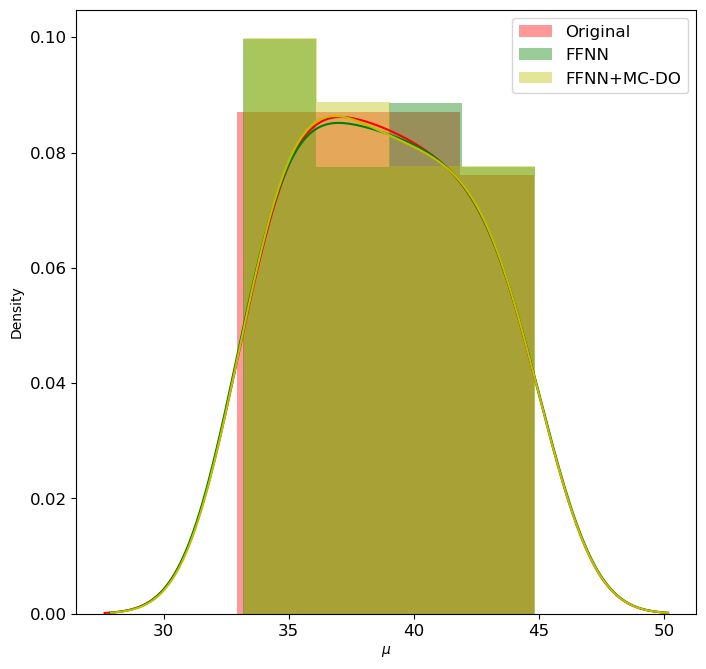

In [32]:
plt.figure(figsize=(8, 8), dpi=100)

sns.distplot(dist, color='r', label='Original')
sns.distplot(dlfake, color='g', label='FFNN')
sns.distplot(dlfake_do, color='y', label='FFNN+MC-DO')
plt.xlabel('$\mu$')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)

<AxesSubplot:>

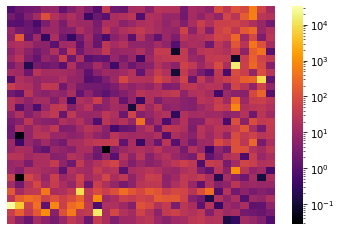

In [33]:
perc_matrix = 100*np.abs((syscov - newmatrixr_do)/ syscov)
sns.heatmap(perc_matrix, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True, norm=LogNorm() )

In [34]:
z_sample = np.array([mean_ref+delta_mean])

newmatrix_ref = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr_ref = newmatrix_ref.reshape(31,31)

<AxesSubplot:>

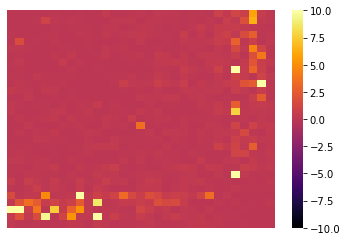

In [35]:
perc_matrix =np.abs((syscov - newmatrixr_ref)/ syscov)

sns.heatmap(perc_matrix, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True, vmax=10, vmin=-10)

In [36]:
np.max(perc_matrix)

325.80767102790657

In [37]:
( perc_matrix > 100).sum()

3

In [38]:
(perc_matrix > 5).sum()

15

In [39]:
( perc_matrix > 1).sum()

64

In [40]:
( perc_matrix < 1).sum()

897